# Attention is all you Need Vanilla Transformer
The Transformer model is also based on the encoder-decoder architecture. It, however, differs to the seq2seq model that the transformer replaces the recurrent layers in seq2seq with attention layers.

This notebook will implement/explain each block.

### Sequence to Sequence vs Transformer
![alt text](docs/imgs/seq2seq_vs_transformer.png "Title")

### Encoder Decoder Stack
Actually both encoder/decoder are a stack of blocks (on the paper with size N=6). In practice you can use other sizes.

![alt text](docs/imgs/encoder_decoder_stack.png "Title")

Each encoder sub-block, is made by a Multi-Head self attention block and a Positional Feed Forward Layer. The exact same feed-forward network is independently applied to each position, but with different weights at each head of the multi-head attention.

### Input/Output Embedding
Similar to the Seq2Seq architecture the Embedding layer will use training data to find the best representation of your vocabullary (ie: Word2Vec).
In other words this layer will transform each input word(index) into a vector using the [embedding algorithm](https://medium.com/deeper-learning/glossary-of-deep-learning-word-embedding-f90c3cec34ca).

![alt text](docs/imgs/embedding.png "Title")

Note: Even if your data are not "words" (ie: handwriting features) it's good practice to use the embedding layer to find the best representation to your data. As usual on Machine Learning try and check if it helps.

### Positional Encoding
One of the biggest advantage of the transformer architecture is that we can compute things in parallel independently because we give the whole sequence to the model disregarding it's order, this layer gives back the sequence information by adding some sort of index to the embedding information.

![alt text](docs/imgs/pos_encoding.png "Title")

### Attention Mechanism
Going back to the seq2seq with attention, the decoder had access to the whole encoded input sequence, but sometimes it's important to know how a specific word at the output relates to some (or specific) token on the input instead of having to take into consideration the whole input signal. 

The attention layer is responsible to make this relation explicit, the input of the attention layer is called a query, for a specific query this layer returns an output based on some memory, which is a set of key-value pairs, on the transformer.

![alt text](docs/imgs/attention_simple.png "Title")

#### Attention main components
The first thing the attention need to do is to find the similarity between a query and a key, this is done by a score function that return n scores for each input element of the input sequence.

$$
a_i = \alpha(\mathbf q, \mathbf k_i)
$$

Different score functions will dictate the type of attention you create, on the transformer case we use a variant of the dot product attention.

After the score function generate scores we use a softmax layer to convert those scores to probabilities:

$$
b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).
$$

Then those probabilities (sometimes called attention weights) are applied to the values, here "n" is the number of key/value pairs on memory.

$$
\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.
$$

##### Dot Product Attention
On this attention we consider that the query has same dimension as our keys, so we can use a inner product to calculate how much the pair query/key are similar.

$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

As mentioned this type of attention is used on the transformer architecture with a small change that we divide the whole inner product by $\sqrt{d_k}$ to make the score less sensitive to the input size (number of time-steps, or sequence lenght).
Check [here](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) for more informations on attention.


### Multi Head Attention
The most important aspect of this architecture is the usage of the Multi-Head Attention block, this block is used on the Encoder/Decoder and in between:
* Encoder (Self-Attention at input), Query==Key==Value
* Decoder (Masked Self-Attention at output), Query==Key==Value
* Between Encoder-Decoder (Encoder Key==Value), Query==Decoder Self-Attention

![alt text](docs/imgs/IntroTransformer.png "Title")

The difference of the Multi-Head attention is that it allows the same concept to be attented at multiple "h" levels of representation.

### Position Wise Feed Forward Layer
This layer apply the same transformation to different elements on the sequence but use different weights for each layer of representation from the encoder/decoder. Ther other usager of this layer is to reduce the feature size. This layer has the following objectives:
* Reduce the feature size (Most of the parameters of transformers are on this layer)
* Give to the Multi-Head attention some sort of persistent memory (Like scratch-pad memory)

On this [paper](https://arxiv.org/pdf/1907.01470.pdf) the authors merge the Multi-Head attention and the Feed Forward layer together.

In fact, self-attention and feedforward sublayers, should be regarded as a single mechanism that gathers information from the context and transforms it into a rich representation.

### Add and Norm(LayerNorm)
This layer is used to combine the input/output of the following blocks:
* Multi-Head Attention
* Position Wise Feed Forward

![alt text](docs/imgs/add_norm_block.png "Title")

The usage of this layer on the architecuture is to force the model to converge faster and to allow the model to be deeper.

![alt text](docs/imgs/layer_residuals_details.png "Title")

#### LayerNorm
Layer normalization is a normalization method similar to batch normalization with the difference that the mean and variances are calculated along the last dimension (axis=-1) which is normally the features dimensions.
With LayerNorm, the statistics are computed across each feature and are independent of other examples. The independence between inputs means that each input has a different normalization operation. Considering that your data has shape [batch x sequence x features]

#### Residuals
Residuals are used to make the training of very deep models easier because the residual path will act as a gradient highway, improving the vanishing gradient issue during backpropagation. Residuals are just applying the input signal back to the output.

### References
* [LayerNorm paper](https://arxiv.org/abs/1607.06450)
* [Attention is all you need blog](https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.XXLlHKeZPys)
* [How to code the transformer in pytorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec)
* [Multiheaded Attention Pytorch Docs](https://pytorch.org/docs/stable/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention)
* [Transformer from Pytorch Docs](https://pytorch.org/docs/stable/nn.html?highlight=transformer#torch.nn.Transformer)
* [Nice working reference](https://github.com/dreamgonfly/Transformer-pytorch)
* [Notebook compatible with Pytorch 1.0](https://github.com/ArdalanM/annotated-transformer/blob/fix_pytorch_1.0_plus/The%20Annotated%20Transformer.ipynb)
* [Nice Tutorial on Transformers with MxNet](https://www.d2l.ai/chapter_attention-mechanism/transformer.html)
* [Attention Mechanism](https://www.d2l.ai/chapter_attention-mechanism/attention.html)

In [1]:
import copy
import math

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

import utils_transformer as utils

import matplotlib.pyplot as plt
print("PyTorch Version: ",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
num_gpu = torch.cuda.device_count()
print('Number of GPUs Available:', num_gpu)

PyTorch Version:  1.1.0
Device: cuda:0
Number of GPUs Available: 8


#### HyperParameters

In [2]:
batch_size = 2
sequence_length = 6
hidden_size = 16
attention_heads = 8

#### Attention
In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

![alt text](docs/imgs/attention_block.png "Title")

In [3]:
# Implement attention (Scaled Dot Product)
def attention(query, key, value, dropout=None):
    d_k = query.size(-1)
    key = key.transpose(-2, -1)
    scores = torch.matmul(query, key) / math.sqrt(d_k)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    attention_result = torch.matmul(p_attn, value)
    return attention_result, p_attn

#### MultiHeaded Attention
The MultiHeaded attention block allows us to attend to the same concept at different levels of representation (N)
![alt text](docs/imgs/multi_head_attention_blk.png "Title")

In [4]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, hidden_size, linears=True, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert hidden_size % h == 0
        # We assume d_v always equals d_k
        self.d_k = hidden_size // h
        self.h = h
        if linears: 
            self.linears = utils.clones(nn.Linear(hidden_size, hidden_size), 4)
        else:
            self.linears = [lambda arg: arg] * 4
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from hidden_size => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        # Get result from last linear
        x = self.linears[-1](x)
        return x

In [5]:
mha = MultiHeadedAttention(h=attention_heads, hidden_size=hidden_size)
print("With as many attention queries as there are values:\n")
query = torch.tensor(np.ones([batch_size, 1, hidden_size])).float()
value = torch.tensor(np.ones([batch_size, sequence_length, hidden_size])).float()
result = mha.forward(query, value, value)
print("query:", query.size())
print("value:", value.size())
print("result:", result.size())
print("\n")

With as many attention queries as there are values:

query: torch.Size([2, 1, 16])
value: torch.Size([2, 6, 16])
result: torch.Size([2, 1, 16])




#### Position Wise Feed Forward
The idea of this layer is to apply the same FC layer accross different positions(time-steps) on the input, but with different parameters for each layer of the encoder and decoder.

This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                      
For example, if input sequence = <x1,x2…xm>, total size of position are m .

Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [6]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [7]:
print('sequence_length:', sequence_length)
ffn = PositionwiseFeedForward(4, 8, dropout=0.0)
in_test = torch.tensor(np.ones([batch_size, sequence_length, 4])).float()
ffn_result = ffn(in_test)
print(ffn_result[0])
print('Pointwise Feed Forward shape:', ffn_result.shape)

sequence_length: 6
tensor([[ 0.3489, -0.2257,  0.2118,  0.0218],
        [ 0.3489, -0.2257,  0.2118,  0.0218],
        [ 0.3489, -0.2257,  0.2118,  0.0218],
        [ 0.3489, -0.2257,  0.2118,  0.0218],
        [ 0.3489, -0.2257,  0.2118,  0.0218],
        [ 0.3489, -0.2257,  0.2118,  0.0218]], grad_fn=<SelectBackward>)
Pointwise Feed Forward shape: torch.Size([2, 6, 4])


#### Positional Encoding

##### register_buffer
This is typically used to register a buffer that should not to be considered a model parameter. For example, BatchNorm’s running_mean is not a parameter, but is part of the persistent state.

In [8]:
# Implements the sinusoidal positional encoding for non-recurrent neural networks.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        # Few changes to force position/div_term to float
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # Make 'pe' to retain it's value during training (like static variable)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add the sequence information to the input
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

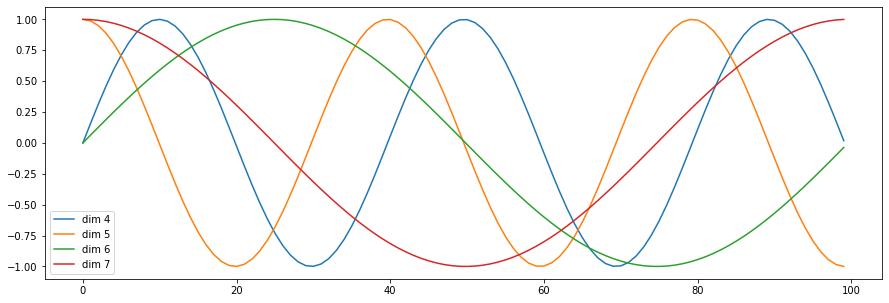

In [11]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None